Project: US Sector Rotation Strategy 

Goal: Predict which US sector ETF will outperform next week/month using historical price data and simple features. Include risk metrics and produce a basic weekly report.

ETFs to consider:

Technology (XLK)

Financials (XLF)

Energy (XLE)

Health (XLV)

Consumer Discretionary (XLY)

Industrials (XLI)

Utilities (XLU)

Materials (XLB)




# Stage01 — Problem Framing & Scoping

Problem: Predict next-week or next-month ETF performance to guide sector rotation.

Deliverables: prediction table, top sectors to invest in, basic risk report.

Assumptions: equal weighting of ETFs, ignore transaction costs for simplicity.

# Stage02 — Tooling Setup & Slides Outline

Python 3, Jupyter/Colab.

Libraries: pandas, numpy, yfinance, scikit-learn, matplotlib, seaborn, statsmodels.

Slides outline: Problem → Data → EDA → Feature Engineering → Modeling → Risk → Results → Conclusion.

# Stage03 — Python Fundamentals

Helper functions for: return calculations, moving averages, labeling performance (up/down), plotting.

# Stage04 — Data Acquisition & Ingestion

Pull historical OHLCV for ETFs from Yahoo Finance (yfinance) over last 5–10 years.

# Stage05 — Data Storage

Save raw data as CSV/Parquet in data/raw.

Store processed features and model outputs in data/processed.

# Stage06 — Data Preprocessing

Fill missing data, align dates.

Compute weekly returns from daily prices.

# Stage07 — Outliers + Risk Assumptions

Winsorize extreme returns (e.g., >3 standard deviations).

Risk assumptions: liquidity sufficient, ignore slippage, no short sales.

# Stage08 — Exploratory Data Analysis

Plot ETF return distributions, correlations, weekly return trends.

Visualize volatility heatmap.

# Stage09 — Feature Engineering

Lagged returns (1–4 weeks).

Rolling mean/volatility (4-week, 12-week).

Momentum indicators.

Label: next-week return or classification (up/down).

# Stage10 — Modeling Random Forest Regression

Random Forest regression: predict next-week return.

Evaluate with RMSE, R².

# Stage11 — Classification

Classification: Random Forest Regression for up/down prediction.

# Stage12 — Results Reporting & Stakeholder Delivery

Generate:

Top sectors to invest.


# Stage 02 — Tooling Setup & Slides Outline

In [4]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Folders
DATA_DIR = "data"
RAW_DIR = os.path.join(DATA_DIR, "raw")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ETFs
etfs = ["XLK","XLF","XLE","XLV","XLY","XLI","XLU","XLB"]
START_DATE = "2016-01-01"
END_DATE = datetime.today().strftime('%Y-%m-%d')

# Stage 03 — Python Fundamentals

In [5]:

import matplotlib.dates as mdates

# Set random seed
def set_seed(seed=42):
    import random
    np.random.seed(seed)
    random.seed(seed)

set_seed(RANDOM_SEED)

# Calculate percentage returns
def pct_change(series):
    return series.pct_change()

# Simple moving average
def sma(series, window=5):
    return series.rolling(window).mean()

# Rolling volatility
def rolling_vol(series, window=5):
    return series.rolling(window).std()

# Plot time series
def plot_series(df, title="Time Series", ylabel="Value"):
    plt.figure(figsize=(12,5))
    plt.plot(df)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Winsorize series
def winsorize_series(series, lower_quantile=0.01, upper_quantile=0.99):
    lower = series.quantile(lower_quantile)
    upper = series.quantile(upper_quantile)
    return series.clip(lower, upper)


# Stage 04 — Data Acquisition & Ingestion

In [6]:
etf_data = {}

for ticker in etfs:
    try:
        tick = yf.Ticker(ticker)
        df = tick.history(start=START_DATE, end=END_DATE)
        if df.empty or 'Close' not in df.columns:
            print(f"Warning: {ticker} missing data. Skipping.")
            continue
        
        # Add 'Adj Close' if missing (sometimes history() only has 'Close')
        if 'Adj Close' not in df.columns:
            df['Adj Close'] = df['Close']
        
        etf_data[ticker] = df
        print(f"Downloaded {ticker} successfully.")
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")

print("Downloaded ETFs:", list(etf_data.keys()))

Downloaded XLK successfully.
Downloaded XLF successfully.
Downloaded XLE successfully.
Downloaded XLV successfully.
Downloaded XLY successfully.
Downloaded XLI successfully.
Downloaded XLU successfully.
Downloaded XLB successfully.
Downloaded ETFs: ['XLK', 'XLF', 'XLE', 'XLV', 'XLY', 'XLI', 'XLU', 'XLB']


# Stage 05 — Data Storage

In [7]:
# Save raw ETF data
for ticker, df in etf_data.items():
    df.to_csv(f"{RAW_DIR}/{ticker}.csv")
print("Raw ETF data saved in:", RAW_DIR)

Raw ETF data saved in: data\raw


# Stage 06 — Data Preprocessing

In [8]:
weekly_data = {}

for ticker, df in etf_data.items():
    # Ensure 'Adj Close' exists
    if 'Adj Close' not in df.columns:
        print(f"Skipping {ticker}, 'Adj Close' not found.")
        continue

    df_weekly = df[['Adj Close']].copy()
    df_weekly = df_weekly.resample('W-FRI').last()  # weekly close
    df_weekly['Return'] = df_weekly['Adj Close'].pct_change()

    # Winsorize returns for outliers (Stage07)
    df_weekly['Return'] = winsorize_series(df_weekly['Return'])

    weekly_data[ticker] = df_weekly.dropna()

# Combine weekly returns into single DataFrame
returns_df = pd.concat([weekly_data[t]['Return'].rename(t) for t in weekly_data.keys()], axis=1)

# Save processed returns
returns_df.to_csv(f"{PROCESSED_DIR}/weekly_returns.csv")
print("Processed weekly returns saved in:", PROCESSED_DIR)
returns_df.head()

Processed weekly returns saved in: data\processed


,XLK,XLF,XLE,XLV,XLY,XLI,XLU,XLB
Date,,,,,,,,
2016-01-15 00:00:00-05:00,-0.018708,-0.030769,-0.030330,-0.016907,-0.028665,-0.021521,0.006959,-0.045182
2016-01-22 00:00:00-05:00,0.026436,-0.006536,0.025575,0.014655,0.025315,-0.000206,0.008984,0.006797
2016-01-29 00:00:00-05:00,0.021298,0.020677,0.044313,-0.020339,0.010912,0.027755,0.036986,0.006751
2016-02-05 00:00:00-05:00,-0.042193,-0.035451,-0.038997,-0.031142,-0.053299,0.001000,0.025319,0.047460
2016-02-12 00:00:00-05:00,-0.005822,-0.021957,-0.011798,-0.000466,-0.005274,-0.007394,-0.021688,-0.016499


## Stage 07 — Outliers & Risk Assumptions
# Risk assumptions

- Liquidity is sufficient for ETF trading
- Ignore transaction costs and slippage
- No short selling
- Equal-weighted portfolio if multiple ETFs selected
- Outliers are rare events


Number of outlier weeks per ETF:
 XLK    0
XLF    6
XLE    6
XLV    6
XLY    0
XLI    0
XLU    7
XLB    7
dtype: int64


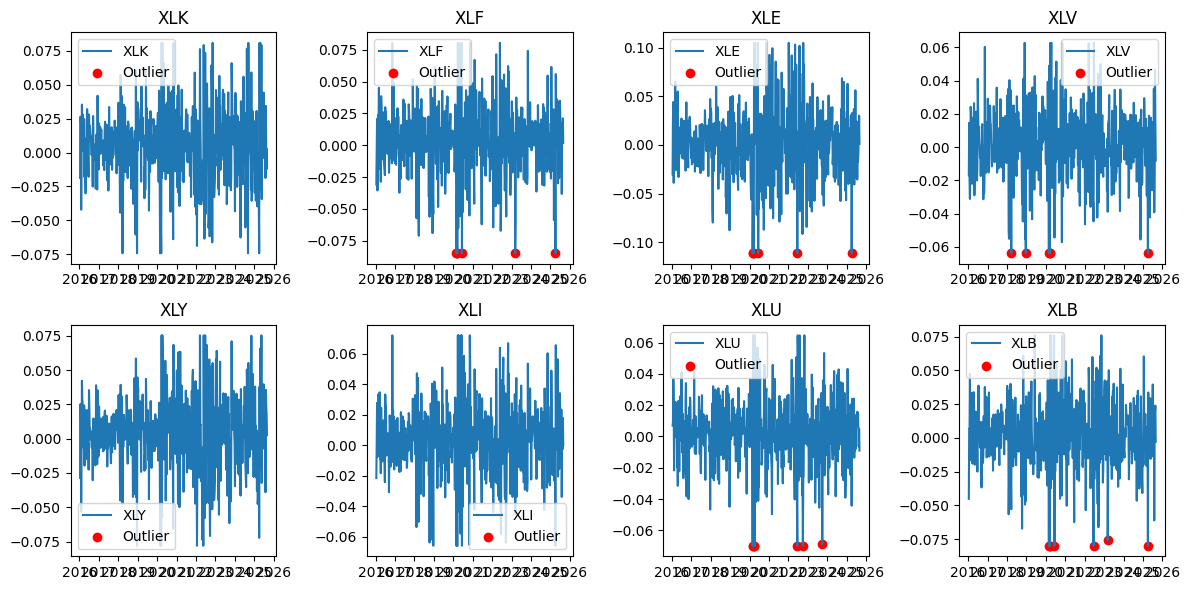

Weekly rolling volatility (last 5 weeks):
                                XLK       XLF       XLE       XLV       XLY  \
Date                                                                          
2025-08-01 00:00:00-04:00  0.016093  0.025195  0.027468  0.032420  0.022783   
2025-08-08 00:00:00-04:00  0.022748  0.024994  0.020333  0.032232  0.031164   
2025-08-15 00:00:00-04:00  0.022104  0.025597  0.013978  0.039509  0.032822   
2025-08-22 00:00:00-04:00  0.023730  0.026564  0.020697  0.036092  0.033171   
2025-08-29 00:00:00-04:00  0.020039  0.008004  0.016190  0.025648  0.013711   

                                XLI       XLU       XLB  
Date                                                     
2025-08-01 00:00:00-04:00  0.024399  0.004186  0.036015  
2025-08-08 00:00:00-04:00  0.024545  0.005363  0.039142  
2025-08-15 00:00:00-04:00  0.024094  0.009160  0.040923  
2025-08-22 00:00:00-04:00  0.022343  0.008840  0.040933  
2025-08-29 00:00:00-04:00  0.009155  0.007266  0.011926 

In [9]:
from scipy.stats import zscore
# Outlier detection using z-score
z_scores = returns_df.apply(zscore)
outlier_flags = (z_scores.abs() > 3)
outliers_count = outlier_flags.sum()
print("Number of outlier weeks per ETF:\n", outliers_count)

# Visualize outliers
plt.figure(figsize=(12,6))
for i, ticker in enumerate(etfs):
    plt.subplot(2,4,i+1)
    plt.plot(returns_df[ticker], label=ticker)
    plt.scatter(returns_df.index[outlier_flags[ticker]], returns_df[ticker][outlier_flags[ticker]],
                color='red', label='Outlier')
    plt.title(ticker)
    plt.legend()
plt.tight_layout()
plt.show()

# Risk metrics
weekly_vol = returns_df.rolling(4).std()
max_drawdown = (returns_df.cumsum() - returns_df.cumsum().cummax()).min()
print("Weekly rolling volatility (last 5 weeks):")
print(weekly_vol.tail())
print("Max drawdown (total period) per ETF:")
print(max_drawdown)


# Stage 08 — Exploratory Data Analysis

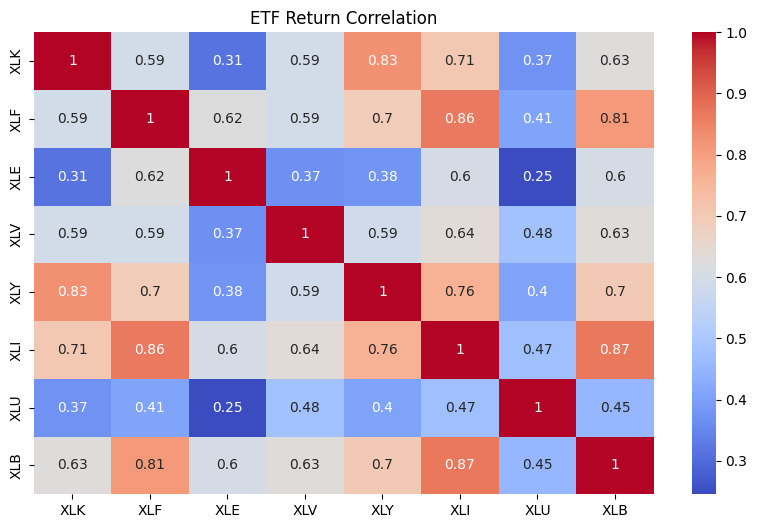

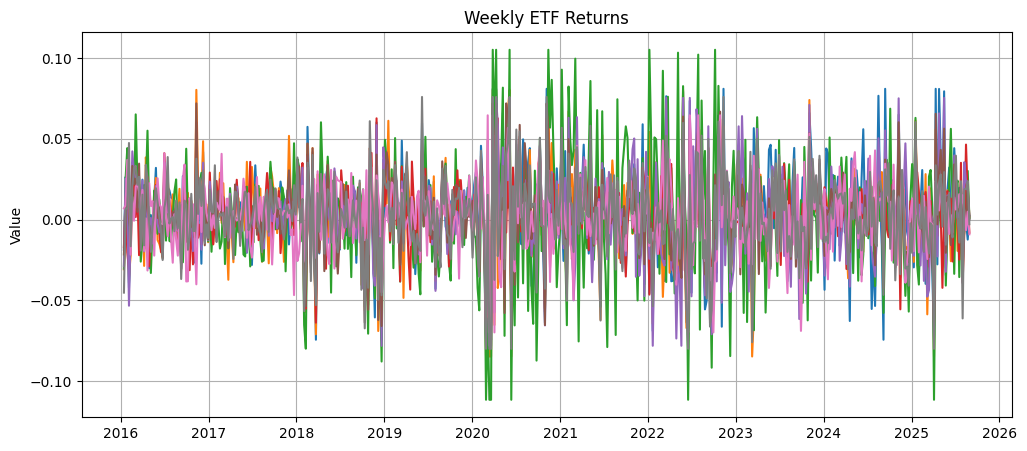

In [10]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(returns_df.corr(), annot=True, cmap="coolwarm")
plt.title("ETF Return Correlation")
plt.show()

# Weekly returns plot
plot_series(returns_df, title="Weekly ETF Returns")



# Stage 09 — Feature Engineering

In [11]:
features = pd.DataFrame(index=returns_df.index)

for ticker in returns_df.columns:
    # Lagged returns for this ETF
    for lag in range(1,5):
        features[f"{ticker}_lag{lag}"] = returns_df[ticker].shift(lag)
    # Rolling volatility
    features[f"{ticker}_vol4"] = returns_df[ticker].rolling(4).std()
    features[f"{ticker}_vol12"] = returns_df[ticker].rolling(12).std()
    
# Cross-ETF momentum features (mean of other ETFs’ lagged returns)
for ticker in returns_df.columns:
    others = [t for t in returns_df.columns if t != ticker]
    features[f"{ticker}_cross_mom4"] = returns_df[others].rolling(4).mean().shift(1).mean(axis=1)

labels = returns_df.shift(-1)
features = features.dropna()
labels = labels.loc[features.index]

# Save features and labels
PROCESSED_DIR = "D:/bootcamp_Jinay_Jain/project/data/processed"
import os
os.makedirs(PROCESSED_DIR, exist_ok=True)

features.to_csv(f"{PROCESSED_DIR}/features.csv")
labels.to_csv(f"{PROCESSED_DIR}/labels.csv")

print("Features and labels saved successfully.")


Features and labels saved successfully.


# Stage 10 — Linear Regression (CAPM)

In [12]:
from sklearn.ensemble import RandomForestRegressor
predictions_rf = pd.DataFrame(index=features.index, columns=returns_df.columns)

for ticker in returns_df.columns:
    X = features[[c for c in features.columns if c.startswith(ticker)]]
    y = labels[ticker]
    mask = ~y.isna()
    X, y = X.loc[mask], y.loc[mask]
    
    # Train-test split
    split = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    predictions_rf.loc[y_test.index, ticker] = y_pred
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{ticker} RF RMSE (test): {rmse:.5f}")


XLK RF RMSE (test): 0.03264
XLF RF RMSE (test): 0.02592
XLE RF RMSE (test): 0.03300
XLV RF RMSE (test): 0.02111
XLY RF RMSE (test): 0.02803
XLI RF RMSE (test): 0.02262
XLU RF RMSE (test): 0.02058
XLB RF RMSE (test): 0.02493


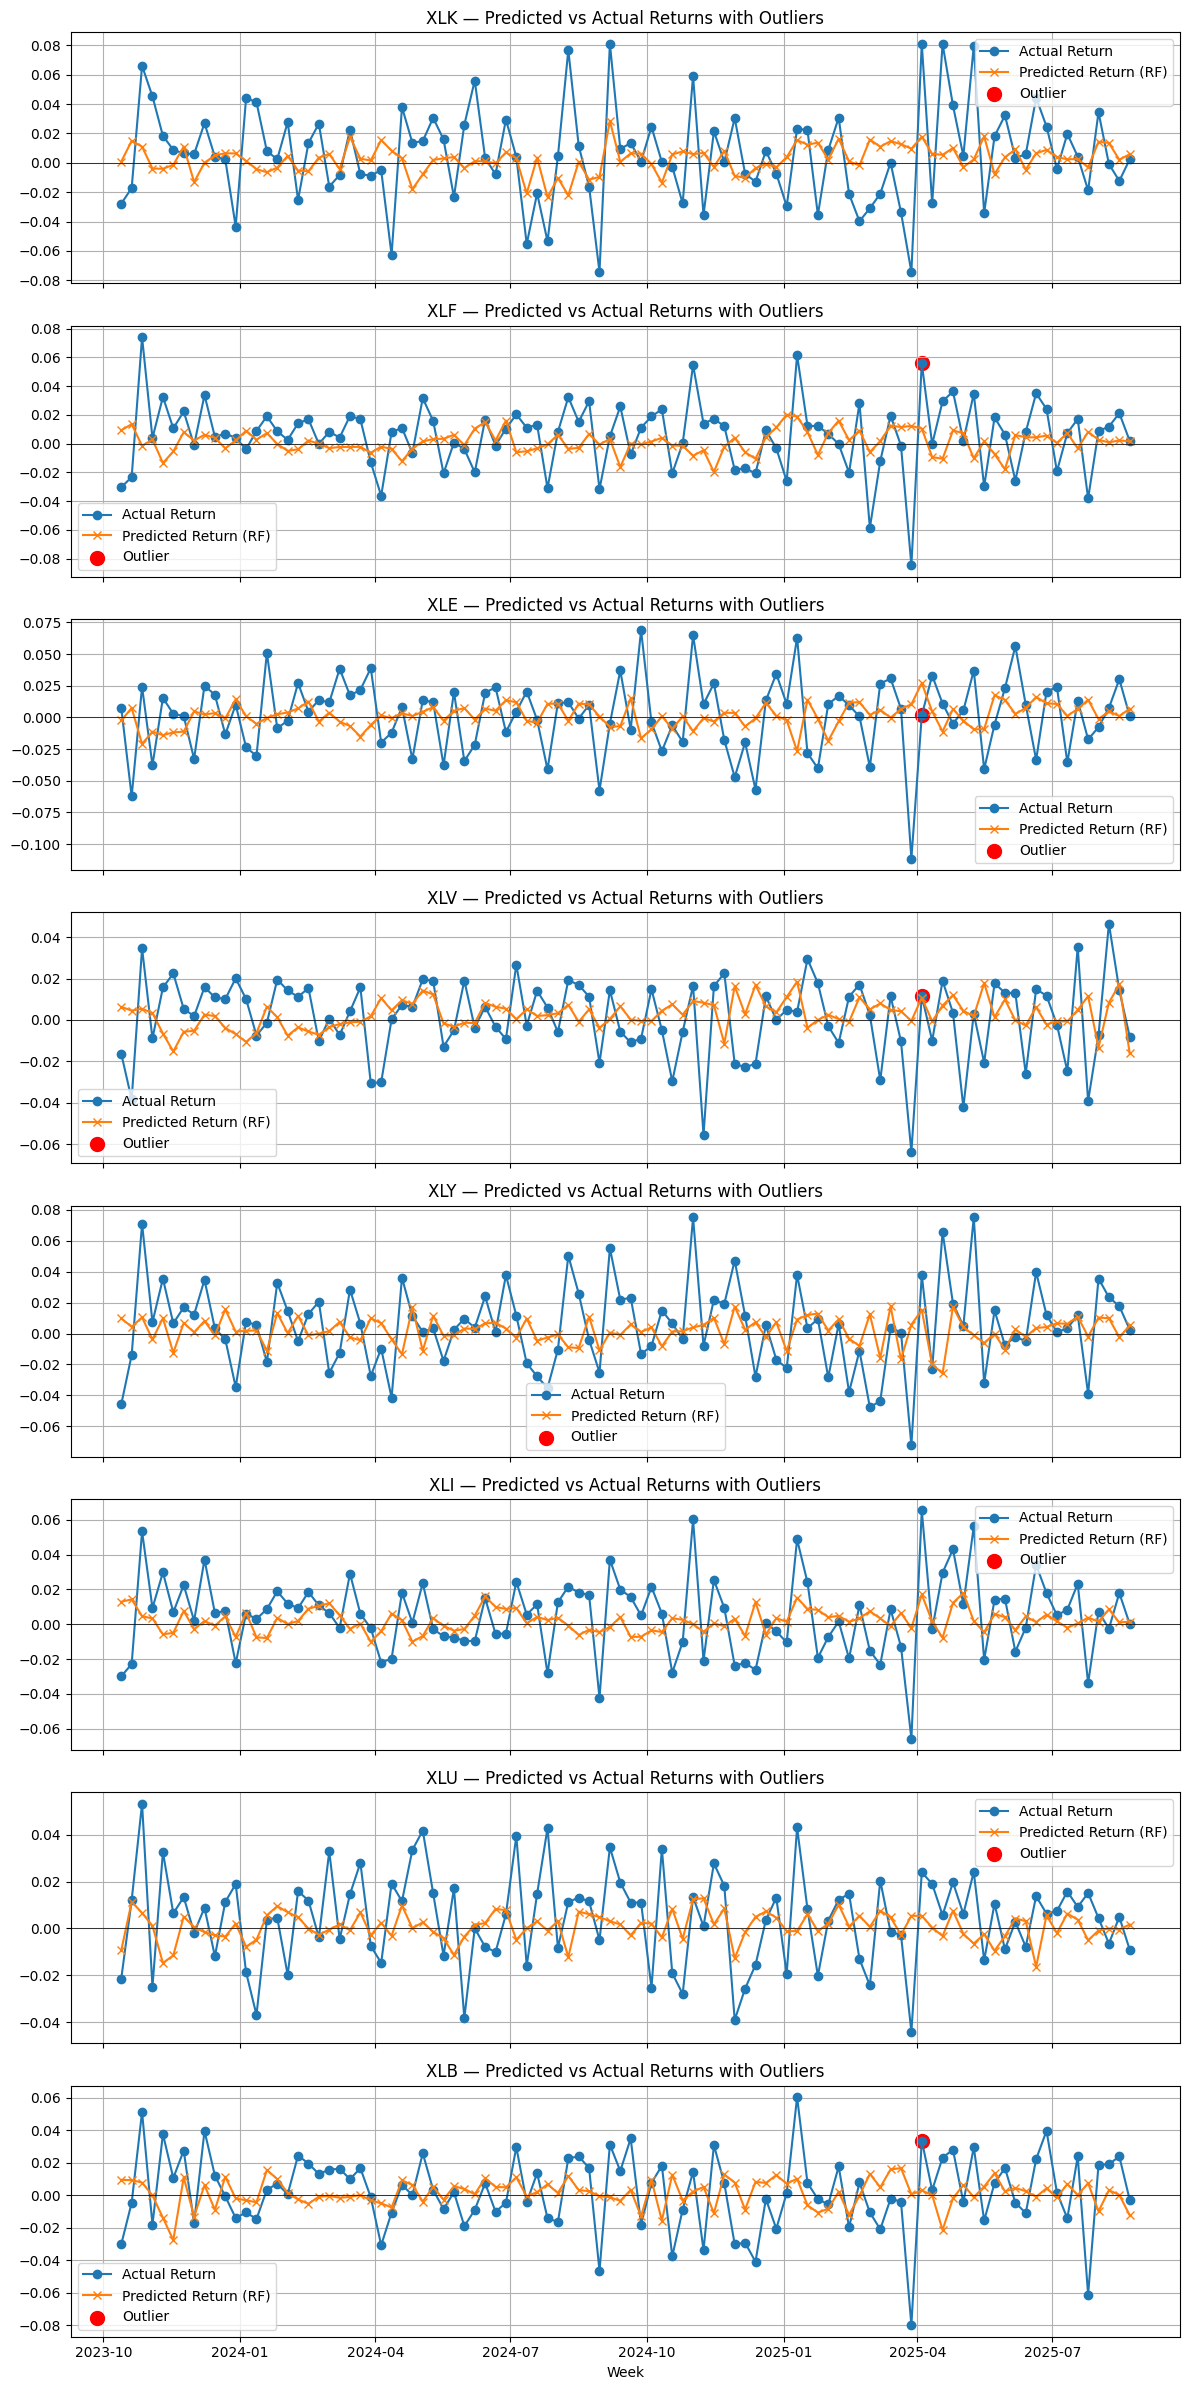

In [13]:
fig, axes = plt.subplots(len(returns_df.columns), 1, figsize=(12, 3*len(returns_df.columns)), sharex=True)

for i, ticker in enumerate(returns_df.columns):
    ax = axes[i]
    # Actual returns (test period)
    y_test = labels[ticker].iloc[int(0.8*len(labels)):]
    y_pred = predictions_rf[ticker].loc[y_test.index]
    
    ax.plot(y_test.index, y_test.values, label="Actual Return", marker='o')
    ax.plot(y_pred.index, y_pred.values, label="Predicted Return (RF)", marker='x')
    
    # Highlight outliers
    outlier_idx = outlier_flags[ticker].loc[y_test.index]
    ax.scatter(outlier_idx.index[outlier_idx], y_test[outlier_idx], color='red', s=100, label="Outlier")
    
    ax.set_title(f"{ticker} — Predicted vs Actual Returns with Outliers")
    ax.axhline(0, color='black', linewidth=0.5)
    ax.grid(True)
    ax.legend()

plt.xlabel("Week")
plt.tight_layout()
plt.show()

# Stage 11 — Time Series & Classification

In [14]:
from sklearn.ensemble import RandomForestClassifier
predictions_clf = pd.DataFrame(index=features.index, columns=returns_df.columns, dtype=int)

for ticker in returns_df.columns:
    X = features[[c for c in features.columns if c.startswith(ticker)]]
    y = (labels[ticker] > 0).astype(int)
    mask = ~y.isna()
    X, y = X.loc[mask], y.loc[mask]
    
    split = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test).astype(int)
    predictions_clf.loc[y_test.index, ticker] = y_pred
    
    acc = accuracy_score(y_test, y_pred)
    print(f"{ticker} Up/Down Accuracy (test set): {acc:.2f}")

XLK Up/Down Accuracy (test set): 0.46
XLF Up/Down Accuracy (test set): 0.51
XLE Up/Down Accuracy (test set): 0.56
XLV Up/Down Accuracy (test set): 0.52
XLY Up/Down Accuracy (test set): 0.59
XLI Up/Down Accuracy (test set): 0.60
XLU Up/Down Accuracy (test set): 0.63
XLB Up/Down Accuracy (test set): 0.54


## Stage 12 — Results Reporting & Stakeholder Delivery


In [23]:


import pandas as pd

# Align the last prediction for each ETF with its label index
latest_pred_return = pd.Series(index=returns_df.columns, dtype=float)

for ticker in returns_df.columns:
    preds = predictions_rf[ticker].dropna()
    if len(preds) > 0:
        latest_pred_return[ticker] = preds.iloc[-1]  # last available prediction
    else:
        latest_pred_return[ticker] = 0.0  # fallback if no prediction


report = pd.DataFrame({
    "ETF": returns_df.columns,
    "Predicted_NextWeek_Up": latest_pred_class.values,
    "Predicted_Return_RF": latest_pred_return.values,
})

# Sort ETFs by predicted return (descending)
report = report.sort_values(by="Predicted_Return_RF", ascending=False).reset_index(drop=True)

# Highlight top sectors
top_sectors = report.loc[report["Predicted_NextWeek_Up"] == 1, "ETF"].tolist()
print("Top sectors to invest next week:", top_sectors)

# Save report
report.to_csv(f"{PROCESSED_DIR}/weekly_report_RF.csv", index=False)
report



Top sectors to invest next week: ['XLK', 'XLY', 'XLI', 'XLB']


,ETF,Predicted_NextWeek_Up,Predicted_Return_RF
0,XLE,0.0,0.006883
1,XLK,1.0,0.005845
2,XLY,1.0,0.005222
3,XLU,0.0,0.001673
4,XLI,1.0,0.001531
5,XLF,0.0,0.001527
6,XLB,1.0,-0.012328
7,XLV,0.0,-0.016100
